In [1]:
import openferro as of
from openferro.interaction import *
from openferro.simulation import *
from openferro.engine import *
from openferro.ewald import get_dipole_dipole_ewald
from matplotlib import pyplot as plt
import json


# define the lattice, order parameters, and the Hamiltonian

In [12]:
L = 10
config = json.load(open('../model_configs/BaTiO3.json'))
latt_vecs = jnp.eye(3) * config['lattice']['a1']
latt = of.BravaisLattice3D(L, L, L, latt_vecs[0], latt_vecs[1], latt_vecs[2])
bto = of.System(latt, pbc=True)

## define fields
dipole_field = bto.add_field(name="dipole", ftype="Rn", dim=3, value=0.1, mass = 40)
lstrain_field = bto.add_field(name="lstrain", ftype="local_strain", value=0.0, mass = 40)
gstrain_field = bto.add_field(name="gstrain", ftype="global_strain", value=jnp.zeros(6), mass = 40 * L**3)

## define Hamiltonian
bto.add_self_interaction('self_onsite', field_name="dipole", energy_engine=self_energy_onsite_isotropic, parameters=config["onsite"], enable_jit=True)
bto.add_self_interaction('short_range_1', field_name="dipole", energy_engine=short_range_1stnn_isotropic, parameters=config["short_range"], enable_jit=True)
bto.add_self_interaction('short_range_2', field_name="dipole", energy_engine=short_range_2ednn_isotropic, parameters=config["short_range"], enable_jit=True)
bto.add_self_interaction('short_range_3', field_name="dipole", energy_engine=short_range_3rdnn_isotropic, parameters=config["short_range"], enable_jit=True)
bto.add_self_interaction('dipole_dipole', field_name="dipole", energy_engine=get_dipole_dipole_ewald(latt), parameters=config["born"], enable_jit=True)


homo_config = config["elastic"].copy()
homo_config['N'] = L**3
bto.add_self_interaction('homo_elastic', field_name="gstrain", energy_engine=homo_elastic_energy, parameters=homo_config, enable_jit=True)
bto.add_mutual_interaction('homo_strain_dipole', field_name1="gstrain", field_name2="dipole", energy_engine=homo_strain_dipole_interaction, parameters=config["elastic_dipole"], enable_jit=True)

# bto.add_mutual_interaction('elastic', field_name1="lstrain", field_name2="gstrain", energy_engine=elastic_energy, parameters=config["elastic"], enable_jit=True)
# bto.add_mutual_interaction('inhomo_strain_dipole', field_name1="lstrain", field_name2="dipole", energy_engine=inhomo_strain_dipole_interaction, parameters=config["elastic_dipole"], enable_jit=True)
 

# structure relaxation

In [13]:

# check all energy terms before structural minimization
# bto.update_force()
# print('max force before optimization',jnp.abs(bto.get_field_by_name("dipole").get_force()).max())
# print('average field before optimization',bto.get_field_by_name("dipole").get_values().mean())
# for interaction in bto.interaction_dict:
#     print('E({})={}eV'.format( interaction, bto.calc_energy_by_name(interaction)))
#     # %timeit bto.calc_energy_by_name(interaction)
#     # %timeit bto.calc_force_by_name(interaction)
# print('total E:{}eV'.format(bto.calc_potential_energy()))

## minimization
hydropres =  -4.8e4
minimizer = MDMinimize(bto, max_iter=10000, tol=1e-5, dt=0.01)
minimizer.minimize(variable_cell=True, pressure=hydropres)

## check strain and spontaneous poalrization after structural minimization 
equilibrium_field = bto.get_field_by_name("dipole").get_values().copy()
avg_field = equilibrium_field.mean((0,1,2))
polarization = avg_field * config['born']['Z_star'] / latt.unit_volume * 16.0217646  # C/m^2
strain4 = - config['elastic_dipole']['B4yz'] / config['elastic']['B44'] * avg_field[1] * avg_field[2]
strain5 = - config['elastic_dipole']['B4yz'] / config['elastic']['B44'] * avg_field[0] * avg_field[2]
strain6 = - config['elastic_dipole']['B4yz'] / config['elastic']['B44'] * avg_field[0] * avg_field[1]
strain1 = - 0.5 * (config['elastic_dipole']['B1xx']+2*config['elastic_dipole']['B1yy']) * avg_field[0]**2
strain1 -= hydropres * Constants.bar * latt.unit_volume
strain1 /= (config['elastic']['B11']+2*config['elastic']['B12'])

print('max force after optimization',jnp.abs(bto.get_field_by_name("dipole").get_force()).max())
print('numerical   global strain:', bto.get_field_by_name("gstrain").get_values())
print('theoretical global strain=({:.4f},**,**,{:.4f},{:.4f},{:.4f})'.format(strain1, strain4, strain5, strain6))
# for interaction in bto.interaction_dict:
#     print('E({})={}eV'.format( interaction, bto.calc_energy_by_name(interaction)))
# print('total E:{}eV'.format(bto.calc_potential_energy()))
# print('average field after optimization',avg_field)
print('spontaneous polarization = {} C/m^2'.format(polarization))
print('|polarization|={}C/m^2'.format((polarization**2).sum()**0.5))


max force after optimization 1.4871359e-05
numerical   global strain: [[[[0.01488727 0.01461967 0.01461938 0.00162759 0.00164496 0.00164497]]]]
theoretical global strain=(0.0148,**,**,0.0016,0.0016,0.0016)
spontaneous polarization = [0.26885566 0.26602113 0.26601335] C/m^2
|polarization|=0.462399959564209C/m^2


# NPT simulation

In [ ]:
temp_list = np.linspace(140, 400, 14 )
# average_field = np.zeros(len(temp_list))
log_freq = 100
total_time = 50
dt = 0.002
relax_steps = int(10/dt)
total_steps = int(total_time / dt)
niters = total_steps // log_freq
field_history = []
gs_history = []
for it, temperature in enumerate(temp_list):
    # simulation = SimulationNVTLangevin(bto, dt=dt, temperature=temperature, tau=0.1)
    simulation = SimulationNPTLangevin(bto, dt=dt, temperature=temperature, pressure=-4.8e4, tau=0.1, tauP= 1)
    simulation.init_velocity(mode='gaussian')
    simulation.step(relax_steps)
    print('T={}K'.format(temperature))
    average_field = []
    global_strain = []
    for ii in range(niters):
        simulation.step(log_freq)
        average_field.append(bto.get_field_by_name('dipole').get_values().mean((0,1,2)))
        global_strain.append(bto.get_field_by_name("gstrain").get_values().flatten())
        if ii % 5 == 0:
            print('=================T={}K, iter={}======================='.format(temperature, ii))
            # pot_E = bto.calc_potential_energy()
            # kin_E = bto.calc_kinetic_energy()
            # total_E = pot_E + kin_E
            # excess_stress = bto.calc_excess_stress().flatten()
            # print('pot energy:', pot_E)
            # print('kine energy:', kin_E)
            # print('total energy:', total_E)
            print('temperature:', bto.calc_temp_by_name('dipole'))
            print('average field: {}A'.format(average_field[-1]))
            print('global strain: {} '.format(global_strain[-1]))
    field_history.append(average_field)
    gs_history.append(global_strain)
field_history = jnp.array(field_history)
gs_history = jnp.array(gs_history)


jnp.save('field_history.npy', field_history)
jnp.save('gs_history.npy', gs_history)


T=140.0K
=================T=140.0K, iter=0=======================
temperature: 131.24251
average field: [0.10340115 0.10253312 0.10155509]A
global strain: [0.01462788 0.0151118  0.01509932 0.00178921 0.00145853 0.00115128] 
=================T=140.0K, iter=5=======================
temperature: 144.07874
average field: [0.10312787 0.10242439 0.10156323]A
global strain: [0.01525554 0.01494322 0.01500947 0.00156117 0.00175583 0.00102558] 
=================T=140.0K, iter=10=======================
temperature: 132.62785
average field: [0.10279677 0.10217315 0.10142382]A
global strain: [0.01534736 0.0149207  0.01479555 0.00149207 0.00209736 0.00099154] 
=================T=140.0K, iter=15=======================
temperature: 131.62152
average field: [0.10270122 0.10188171 0.10116589]A
global strain: [0.01512571 0.01544709 0.01428106 0.00124691 0.00212288 0.00106835] 
=================T=140.0K, iter=20=======================
temperature: 139.79709
average field: [0.10245401 0.10161147 0.10086793

In [23]:
gs_history.shape

(1, 50, 6)

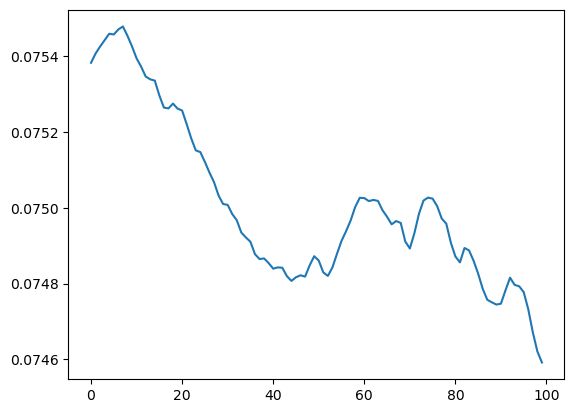

In [23]:
plt.plot(field_history[6], label='20K')
# field_history.shape